<a href="https://colab.research.google.com/github/c0der-aryan/Cloud-Coverage-Prediction/blob/main/FINAL_CCD_LNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ncps lightning wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.1/296.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
 

In [ ]:
#from kaggle_secrets import UserSecretsClient
import wandb
#user_secrets = UserSecretsClient()

# # I have saved my API token with "wandb_api" as Label.
# # If you use some other Label make sure to change the same below.
# wandb_api = user_secrets.get_secret("ncps_lcts_first_ever")

# wandb.login(key=wandb_api)
# print("done")
##import wandb

import os
# Set your W&B API key
os.environ['WANDB_API_KEY'] = '049f7f5bf9ed8b83bbb9e00c95a2a18af319c825'

# Log in to W&B
wandb.login()

print("done")


wandb: Currently logged in as: c0der-aryan (roadkill). Use `wandb login --relogin` to force relogin


done


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for f in filenames:
        pass
#         print(f)
print("done")
import glob
import cv2
import matplotlib.pyplot as plt
import PIL
from datetime import datetime
from tqdm import tqdm
import joblib
import torch
from sklearn.preprocessing import StandardScaler ,MinMaxScaler
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import CfC , LTC
import lightning as L
import torch
from torch.utils.data import Dataset , DataLoader

done


In [ ]:
!kaggle datasets download -d soodaryan/ccd-csv

Dataset URL: https://www.kaggle.com/datasets/soodaryan/ccd-csv
License(s): unknown
 67% 11.0M/16.3M [00:00<00:00, 49.3MB/s]
100% 16.3M/16.3M [00:00<00:00, 58.9MB/s]


In [ ]:
df_path_orig = glob.glob("/content/ccd-csv.zip")
print(df_path_orig)

['/content/ccd-csv.zip']


In [ ]:
def final_preprocessor_my (path , scaler) -> pd.DataFrame  :
    df = pd.read_csv(path , low_memory=False)
    df.dropna(inplace = True , thresh = 3)
    # thresh : cols with more than 3 nans will be dropped
    df.infer_objects (copy = False)
    df["Total Cloud Cover [%]"] = df["Total Cloud Cover [%]"].interpolate(limit = 3 , limit_direction = "both")
    # interpolate : 25 nan 27 then nan -> 26
    def convert_date(date_str):
        month_to_num = {
        'Jan': '01',
        'Feb': '02',
        'Mar': '03',
        'Apr': '04',
        'May': '05',
        'Jun': '06',
        'Jul': '07',
        'Aug': '08',
        'Sep': '09',
        'Oct': '10',
        'Nov': '11',
        'Dec': '12'
        }
        parts = date_str.split('-')
        if len(parts) == 2:
            if parts[0].capitalize() in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
                date_str = '-'.join(parts[::-1])
        month = month_to_num[date_str[3:]]
        date_new = month + date_str[:2]

        return date_new

    def time_to_mins (time) :
        hrs , mins = map(int , time.split(":"))
        tote_mins = hrs*60 + mins
        return tote_mins

    def days_passed(date_str):
        date = datetime.strptime(date_str + "2000" , "%m%d%Y")
        start_of_year = datetime(date.year, 1,1)
        days_passed = (date - start_of_year).days + 1 # +1 to include the current day
        return days_passed
    df["DATE (MM/DD)"] = df["DATE (MM/DD)"].apply(convert_date)
    df["TIME IN MINS"] = df["MST"].apply(time_to_mins)
    df["DAYS"] = df["DATE (MM/DD)"].apply(days_passed)
    df["15 MINS"] = df["Total Cloud Cover [%]"].shift(-15)
    df["25 MINS"] = df["Total Cloud Cover [%]"].shift(-25)
    df["30 MINS"] = df["Total Cloud Cover [%]"].shift(-30)

#     df.dropna(inplace = True , thresh = 3)
#     df.infer_objects (copy = False)
#     df_orig.interpolate(limit = 3 , limit_direction = "both" , inplace = True)

    cols_to_be_scaled_standard = ['Global CMP22 (vent/cor) [W/m^2]',
                                  'Direct sNIP [W/m^2]',
                                  'Tower Dry Bulb Temp [deg C]',
                                  'Tower Wet Bulb Temp [deg C]',
                                  'Tower Dew Point Temp [deg C]',
                                  'Peak Wind Speed @ 6ft [m/s]',
                                  'Avg Wind Direction @ 6ft [deg from N]',
                                  'Station Pressure [mBar]',
                                  'Precipitation (Accumulated) [mm]',
                                  'Snow Depth [cm]', ]

    cols_to_be_scaled_min = [
                             'Azimuth Angle [degrees]',
                             'Moisture',
                             'Tower RH [%]',
                             'Albedo (CMP11)'
                             ]
    cols_y_min = ['Total Cloud Cover [%]' , "15 MINS" , "25 MINS" , "30 MINS"]
    df[cols_to_be_scaled_standard] = scaler[0].fit_transform(df[cols_to_be_scaled_standard])
    df[cols_to_be_scaled_min] = scaler[1].fit_transform(df[cols_to_be_scaled_min])
    df[cols_y_min] = df[cols_y_min]/100
    df.drop(columns = ["DATE (MM/DD)" , "MST"] , inplace = True)
#     to remove last 1 hr  worth info
    return df.iloc[:-60 , :]

scalers = [StandardScaler() , MinMaxScaler() , MinMaxScaler()]
df_final = final_preprocessor_my(df_path_orig[0] , scalers)

joblib.dump(scalers[0], 'standard_scaler.joblib')
joblib.dump(scalers[1], 'min_max_scaler.joblib')
joblib.dump(scalers[2], 'min_max_scaler_main.joblib')

['min_max_scaler_main.joblib']

In [ ]:
df_final.shape

(482340, 20)

In [ ]:
import numpy as np

# Define the dataset size, window length, and gap
dataset_size = 482400
window_length = 30
gap = 10

# Calculate the number of windows
# (dataset_size - window_length) is the maximum start index of a window
# Dividing by gap gives the number of possible windows (integer division)
num_windows = (dataset_size - window_length) // gap + 1

#96403

print(f"Number of sliding windows: {num_windows}")



Number of sliding windows: 48238


In [ ]:
# 482400*4/60/24 - 1
482040*24*2/60/24

16068.0

In [ ]:
df_final.describe()

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11),TIME IN MINS,DAYS,15 MINS,25 MINS,30 MINS
count,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000,482340.000000
mean,0.000086,0.000081,0.499963,0.000228,0.000229,0.000107,0.376602,0.237037,0.000173,0.000169,0.000098,0.000024,-0.000004,0.061662,0.064694,719.414168,167.981465,0.237037,0.237037,0.237037
std,1.000034,1.000037,0.282242,0.999855,0.999852,1.000017,0.250776,0.347794,0.999943,0.999935,1.000025,1.000061,1.000063,0.237755,0.090132,415.647088,96.697573,0.347794,0.347794,0.347794
min,-0.703717,-0.687791,0.000000,-2.756406,-3.265491,-3.025438,0.000000,0.000000,-1.400921,-1.445491,-4.315831,-0.194019,-42.326468,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,-0.691269,-0.654744,0.246038,-0.784112,-0.775865,-0.739406,0.185317,0.000000,-0.683307,-1.062010,-0.602758,-0.194019,0.015395,0.000000,0.000000,359.000000,84.000000,0.000000,0.000000,0.000000
50%,-0.661655,-0.653486,0.499888,0.053188,0.043183,-0.057411,0.306706,0.000000,-0.188401,0.079153,0.090876,-0.194019,0.018433,0.000000,0.000000,719.000000,168.000000,0.000000,0.000000,0.000000
75%,0.500967,0.801964,0.753897,0.785838,0.878108,0.733671,0.508812,0.380000,0.430231,0.979845,0.674712,-0.194019,0.020423,0.000000,0.100900,1079.000000,252.000000,0.380000,0.380000,0.380000
max,4.141654,2.240738,1.000000,2.254919,2.090002,2.749857,1.000000,1.000000,10.204625,1.648488,6.010808,14.423662,0.165450,1.000000,1.000000,1439.000000,335.000000,1.000000,1.000000,1.000000


In [ ]:
class ccd_dataset (Dataset) :
    def __init__(self, X , y , seq_len = 360) :
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.gap = 10
    def __len__ (self):
        len1 = (self.X.shape[0] - self.seq_len) // self.gap + 1
        return len1
        # return len(self.X) - self.seq_len
    def __getitem__(self,idx) :
        x_start = idx * self.gap
        x_end = idx * self.gap + self.seq_len
        y_idx = x_end

        x = self.X.iloc[x_start : x_end].values
        y = self.y.iloc[y_idx].values
        # y = y.reshape(-1,1)

        x = torch.Tensor(x).to(torch.float32)
        y = torch.Tensor(y).to(torch.float32)

        return x , y

In [ ]:
target = ["15 MINS" , "25 MINS" , "30 MINS"]
X = df_final.drop(columns = target)
y = df_final[target]

X.index = list(range(len(X)))
y.index = list(range(len(y)))

split_index = int(len(X) * 0.8)

X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

train_dataset = ccd_dataset(X_train, y_train , seq_len = 30)
val_dataset = ccd_dataset(X_val, y_val , seq_len = 30)

batch_size = 8
train_dataloader = DataLoader (train_dataset , batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader (val_dataset , batch_size = batch_size , shuffle = False)

dataloader_iter = iter(train_dataloader)

x1, y1 = next(dataloader_iter)
print(x1.shape)  # Should print: torch.Size([360, number_of_x_features])
print(y1.shape)  # Should print: torch.Size([number_of_y_features])

torch.Size([8, 30, 17])
torch.Size([8, 3])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
len(train_dataset)

38585

In [ ]:
len(val_dataset)

9644

In [ ]:
# print("len of full dataloader" , len(DataLoader (dataset , batch_size = 16)))
print("len of train dataloader" , len(train_dataloader))
print("len of val dataloader" , len(val_dataloader))

# len of train dataloader 67
# len of val dataloader 17

# len of train dataloader 24080
# len of val dataloader 6003

len of train dataloader 4824
len of val dataloader 1206


In [ ]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="CCD",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "LNN",
    "epochs": 60,
    }
)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

def personal_metrics(y_true , y_pred , y_hat_1 , y_1) :
    y_true = y_true.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()

    y_hat_1 = y_hat_1.cpu().detach().numpy()
    y_1 = y_1.cpu().detach().numpy()

    r2 = r2_score(y_1 , y_hat_1)

    r2_1 = r2_score((100*y_true[ : , 0].reshape(-1)), (100*y_pred[ : , 0].reshape(-1)))
    r2_2 = r2_score((100*y_true[ : , 1].reshape(-1)), (100*y_pred[ : , 1].reshape(-1)))
    r2_3 = r2_score((100*y_true[ : , 2].reshape(-1)), (100*y_pred[ : , 2].reshape(-1)))

    # Custom weighted accuracy
    weighted_accuracy = 0.5 * r2_1 + 0.35 * r2_2 + 0.15 * r2_3

    return (weighted_accuracy , r2 , r2_1 , r2_2 ,r2_3)

y_true = torch.randn(8, 3)
y_pred = torch.randn(8, 3)

y_hat_1 = (100*y_pred.view(-1))
y_1 = (100*y_true.view(-1))

personal_metrics(y_true , y_pred , y_hat_1 , y_1)

(-0.7216015534574858,
 -0.9681709062261148,
 -0.6034138115111429,
 -0.6368994103894572,
 -1.3131990271040288)

In [ ]:
class SequenceLearner(L.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = nn.Sequential(model)
        self.layer = nn.Sequential(nn.ReLU(inplace=True))
        self.lr = lr
        self.save_hyperparameters(ignore=['model'])
        self.optimizer_choice = 'adam'  # Initial optimizer choice
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        x, _ = self.model(x)
        x = self.layer(x)
        return torch.Tensor(x)

    def training_step(self, batch, batch_idx):
      if batch_idx < 4800 :
        if batch_idx  == 0 :
          print("Start")
        x, y = batch

        y_hat = self.forward(x)
        y_hat = y_hat.view_as(y)

        y_hat_1 = (100*y_hat.view(-1))
        y_1 = (100*y.view(-1))

        loss = nn.MSELoss()(y_1 , y_hat_1)

        weighted_accuracy, r2, r2_1, r2_2, r2_3 = personal_metrics(y_hat, y , y_hat_1 , y_1)

        self.log("train_loss", loss, prog_bar=True, sync_dist=True)
        self.train_losses.append(loss.item()/4800)
        # Log metrics only 1 time per epoch
        if batch_idx % (4800-1) == 0 and batch_idx != 0:
            wandb.log({"train_loss": loss, "train_weighted_accuracy": weighted_accuracy, "train_r2": r2})
            print(f" mse: {loss} r2: {r2}, r2_1: {r2_1}, r2_2: {r2_2}, r2_3: {r2_3}, weighted acc: {weighted_accuracy}\t")

        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
      if batch_idx < 1200 :
        x, y = batch
        y_hat = self.forward(x)
        y_hat = y_hat.view_as(y)

        y_hat_1 = (100*y_hat.view(-1))
        y_1 = (100*y.view(-1))

        loss = nn.MSELoss()(y_hat_1, y_1)
        weighted_accuracy, r2, r2_1, r2_2, r2_3 = personal_metrics(y_hat, y , y_hat_1 , y_1)

        self.log("val_loss", loss, prog_bar=True, sync_dist=True)
        self.val_losses.append(loss.item())
        # Log metrics only 3 times per epoch
        if batch_idx % (1200-1) == 0 and batch_idx != 0:
            wandb.log({"val_loss": loss, "val_weighted_accuracy": weighted_accuracy, "val_r2": r2, "val_mse": loss})

            avg_train_loss = sum(self.train_losses)
            avg_val_loss = sum(self.val_losses)
            wandb.log({"avg_train_loss": avg_train_loss, "avg_val_loss": avg_val_loss})

            print(f"batch idx : {batch_idx} avg_train_loss {avg_train_loss} avg_val_loss : {avg_val_loss}")
            self.train_losses.clear()
            self.val_losses.clear()

            return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        if self.optimizer_choice == 'adam':
            # return torch.optim.LBFGS(self.model.parameters(), lr=self.lr)
            return torch.optim.Adam(self.model.parameters(), lr=self.lr)
        elif self.optimizer_choice == 'lbfgs':
            return torch.optim.LBFGS(self.model.parameters(), lr=self.lr)

class CustomCallback(L.Callback):
    def on_epoch_start(self, trainer, pl_module):
        current_epoch = trainer.current_epoch
        print(f"Start of Epoch {current_epoch}")
        epoch_number = 10
        if trainer.current_epoch == epoch_number:
            pl_module.optimizer_choice = 'lbfgs'
            pl_module.trainer.optimizers = pl_module.configure_optimizers()
            print(f"Optimizer changed to LBFGS at epoch {epoch_number}")

        wandb.log({"epoch": current_epoch})

    def on_epoch_end(self, trainer, pl_module):
        print(f"End of Epoch {trainer.current_epoch}")
        print("Metrics for Epoch {trainer.current_epoch}:\n")
        metrics = trainer.callback_metrics
        for key, value in metrics.items():
            print(f"{key}: {value}")

        # Calculate and log the average losses
        avg_train_loss = sum(pl_module.train_losses) / len(pl_module.train_losses)
        avg_val_loss = sum(pl_module.val_losses) / len(pl_module.val_losses)
        wandb.log({"avg_train_loss": avg_train_loss, "avg_val_loss": avg_val_loss})

        print("=================================================================")
        print(f"Average train loss: {avg_train_loss}, Average val loss: {avg_val_loss}")

        # Clear the lists for the next epoch
        pl_module.train_losses.clear()
        pl_module.val_losses.clear()


In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',        # Monitor the validation loss
    dirpath='checkpoints',     # Directory to save the checkpoints
    filename='best_model',     # Name of the checkpoint file
    save_top_k=1,              # Save only the best model
    mode='min'                 # Mode to select the best model (min for validation loss)
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    mode="min"
)

out_features = 3
# in_features = 17
in_features = 17

wiring = AutoNCP(24, out_features)

# cfc_model = CfC(in_features, wiring, batch_first=True)
cfc_model = CfC(in_features, wiring, batch_first=True , return_sequences = False)

learn = SequenceLearner(cfc_model, lr=0.001)

trainer = L.Trainer(
    max_epochs=60,
    gradient_clip_val=2,
    accelerator="gpu",
    devices=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


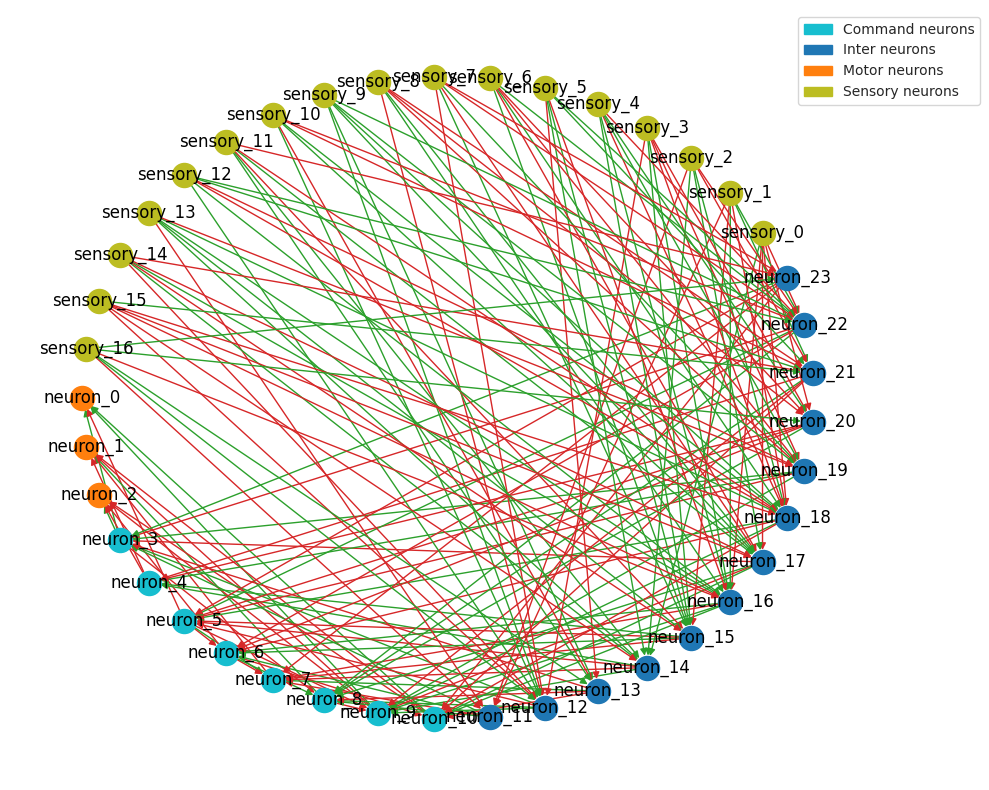

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
plt.figure(figsize=(10, 8))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [ ]:
trainer.fit(learn, train_dataloader, val_dataloader)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 3.1 K  | train
1 | layer | Sequential | 0      | train
---------------------------------------------
2.5 K     Trainable params
591       Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 3.1 K  | train
1 | layer | Sequential | 0      | train
---------------------------------------------
2.5 K     Trainable params
591       Non-trainable params
3.1 K     Total params
0.012     Total est

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

 mse: 105.83673095703125 r2: 0.938550316296573, r2_1: 0.9730949258888956, r2_2: 0.9235426679352509, r2_3: 0.8993494001617774, weighted acc: 0.9446898067460522	


Validation: |          | 0/? [00:00<?, ?it/s]

batch idx : 1199 avg_train_loss 279.759000195154 avg_val_loss : 117197.09044102617


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
# trainer.save_checkpoint("best_model.ckpt")
# Load the best model
best_model_path = checkpoint_callback.best_model_path
best_model = SequenceLearner.load_from_checkpoint(checkpoint_path=best_model_path , model = cfc_model)


In [ ]:
dataloader_iter_val = iter(val_dataloader)

x1, y1 = next(dataloader_iter_val)
x1, y1 = next(dataloader_iter_val)
x1, y1 = next(dataloader_iter_val)
x1, y1 = next(dataloader_iter_val)

x1, y1 = next(dataloader_iter_val)
x1, y1 = next(dataloader_iter_val)
x1, y1 = next(dataloader_iter_val)
x1, y1 = next(dataloader_iter_val)

x1, y1 = next(dataloader_iter_val)
x1, y1 = next(dataloader_iter_val)
x1, y1 = next(dataloader_iter_val)
x1, y1 = next(dataloader_iter_val)

x1, y1 = next(dataloader_iter_val)
x1, y1 = next(dataloader_iter_val)
x1, y1 = next(dataloader_iter_val)
x1, y1 = next(dataloader_iter_val)
print(x1.shape)  # Should print: torch.Size([360, number_of_x_features])
print(y1.shape)  # Should print: torch.Size([number_of_y_features])

In [ ]:
len(val_dataloader)

In [ ]:
# p1 = nn.Linear(17,4)(x1)
# cfc_model(p1)

In [ ]:
wandb.finish()

In [ ]:
best_model.eval()
best_model.freeze()
x1 = x1.to(device)
y_hat = best_model(x1)
print(y_hat.shape == y1.shape)
print(y_hat)

In [ ]:
y1

In [ ]:
learn(x1)

In [ ]:
weighted_accuracy ,  r2 , mse , r2_1 , r2_2 ,r2_3 = personal_metrics(y1 , y_hat)
weighted_accuracy ,  r2 , mse , r2_1 , r2_2 ,r2_3

In [ ]:
# min_max_scaler_main = joblib.load("/kaggle/working/min_max_scaler_main.joblib")
# min_max_scaler_main.inverse_transform(y1)

In [ ]:
# import os
# import pandas as pd

# # Define the log directory
# log_dir = "tb_logs/my_model/version_0/metrics"

# # Read the metrics file
# metrics_df = pd.read_csv(os.path.join(log_dir, "metrics.csv"))

# # Filter the DataFrame to get train and validation loss
# train_loss = metrics_df[metrics_df["tag"] == "train_loss"]["value"].values
# val_loss = metrics_df[metrics_df["tag"] == "val_loss"]["value"].values

# # Plot the loss
# plt.figure(figsize=(10, 5))
# plt.plot(train_loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss Over Epochs')
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # Retrieve the logs
# metrics = trainer.logged_metrics

# train_loss = metrics['train_loss']
# val_loss = metrics['val_loss']

# # Plot the loss
# plt.figure(figsize=(10, 5))
# plt.plot(train_loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss Over Epochs')
# plt.show()


In [ ]:
# # use model after training or load weights and drop into the production system
# model = SequenceLearner.load_from_checkpoint("best_model.ckpt")
# model.eval()
# x = x1
# y = y1
# # trainer.validate(model)
# with torch.no_grad():
#     y_hat_interm, _ = model.forward(x)
#     y_hat = y_hat_interm
#     y_hat = y_hat.view(-1 , y.shape[0] , y.shape[1])[-1]
#     y_hat = y_hat.view_as(y)
#     print(y_hat)

In [ ]:
# trainer.validate()

In [ ]:
# class SequenceLearner (L.LightningModule) :
#     def __init__ (self, model , lr = 0.005) :
#         super().__init__()
# #         49 as in 16*3 as batchsize = 16
#         self.Linear = nn.Linear(17280 , 48)
#         self.model = model
#         self.lr = lr
#         self.save_hyperparameters()
# #         docs say : The arguments passed through LightningModule.__init__() and saved by calling save_hyperparameters() could be accessed by the hparams attribute.

#     def training_step(self, batch , batch_idx) :
#         x , y = batch
#         y_hat_interm, _ = self.model(x)
#         y_hat = self.Linear(y_hat_interm)
#         y_hat = y_hat.view_as(y)

#         loss = nn.MSELoss()(y_hat, y)

#         self.log("train_loss" , loss , prog_bar = True)
#         return {"loss": loss}

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat_interm, _ = self.model(x)
#         y_hat = self.Linear(y_hat_interm)
#         y_hat = y_hat.view_as(y)
#         loss = nn.MSELoss()(y_hat, y)

#         self.log("val_loss", loss, prog_bar=True)
#         return loss

#     def test_step(self, batch, batch_idx):
#         return self.validation_step(batch, batch_idx)

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters, lr=self.lr)